# Occupancy Grid Maps
This notebook allows you to generate an occupancy grid using lidar scanner measurements from a moving vehicle in an unknown environment. A simplified inverse scanner measurement model is used to map these measurements into occupancy probabilities, after which an iterative log-odds update is used to create an occupancy grid belief map. After the car has gathered enough data, the occupancy grid should converge to the true map.

Overview of Tasks:
* Gather range measurements of a moving car's surroundings using a lidar scanning function.
* Extract occupancy information from the range measurements using an inverse scanner model.
* Perform log-odds updates on an occupancy grids based on incoming measurements.
* Iteratively construct a probabilistic occupancy grid from those log odds updates.

Below are some dependencies you need to install for video playback. Make sure you are running this notebook with administrator privileges.

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} ffmpeg

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

The inverse scanner model, implemented as the `inverse_scanner()` function, returns a matrix of measured occupancy probability values based on the lidar scan model. The `get_ranges()` function returns the scanned ranges value for a given vehicle position and scanner bearing.

In [3]:
# Calculates the inverse measurement model for a laser scanner.
# It identifies three regions. The first where no information is available occurs
# outside of the scanning arc. The second where objects are likely to exist, at the
# end of the range measurement within the arc. The third are where objects are unlikely
# to exist, within the arc but with less distance than the range measurement.

def inverse_scanner(num_rows, num_cols, x, y, theta, meas_phi, meas_r, rmax, alpha, beta):
    m = np.zeros((M, N))
    for i in range(num_rows):
        for j in range(num_cols):
            # Find range and bearing relative to the input state (x, y, theta).
            r = math.sqrt((i - x)**2 + (j - y)**2)
            phi = (math.atan2(j - y, i - x) - theta + math.pi) % (2 * math.pi) - math.pi
            
            # Find the range measurement associated with the relative bearing.
            k = np.argmin(np.abs(np.subtract(phi, meas_phi)))
            
            # If the range is greater than the maximum sensor range, or behind our range
            # measurement, or is outside of the field of view of the sensor, then no
            # new information is available.
            if (r > min(rmax, meas_r[k] + alpha / 2.0)) or (abs(phi - meas_phi[k]) > beta / 2.0):
                m[i, j] = 0.5
            
            # If the range measurement lied within this cell, it is likely to be an object.
            elif (meas_r[k] < rmax) and (abs(r - meas_r[k]) < alpha / 2.0):
                m[i, j] = 0.7
            
            # If the cell is in front of the range measurement, it is likely to be empty.
            elif r < meas_r[k]:
                m[i, j] = 0.3
                
    return m
                            

In [4]:
# Generates range measurements for a laser scanner based on a map, vehicle position,
# and sensor parameters.
# Uses the ray tracing algorithm.

def get_ranges(true_map, X, meas_phi, rmax):
    (M, N) = np.shape(true_map)
    x = X[0]
    y = X[1]
    theta = X[2]
    meas_r = rmax * np.ones(meas_phi.shape)
    
    # Iterate for each measurement bearing.
    for i in range(len(meas_phi)):
        # Iterate over each unit step up to and including rmax.
        for r in range(1, rmax+1):
            # Determine the coordinates of the cell.
            xi = int(round(x + r * math.cos(theta + meas_phi[i])))
            yi = int(round(y + r * math.sin(theta + meas_phi[i])))
            
            # If not in the map, set measurement there and stop going further.
            if (xi <= 0 or xi >= M-1 or yi <= 0 or yi >= N-1):
                meas_r[i] = r
                break
            # If in the map, but hitting an obstacle, set the measurement range
            # and stop ray tracing.
            elif true_map[int(round(xi)), int(round(yi))] == 1:
                meas_r[i] = r
                break
                
    return meas_r

In the following code block, we initialize the required variables for our simulation. This includes the initial state as well as the set of control actions for the car. We also set the rate of rotation of our lidar scan. The obstacles of the true map are represented by 1's in the true map, 0's represent free space. Each cell in the belief map `m` is initialized to 0.5 as our prior probability of occupancy, and from that belief map we compute our log-odds occupancy grid `L`.

After each step of robot motion, the code gathers range data from the lidar scan, and then applies the inverse scanner model to map these to a measured occupancy belief map. From this, a log-odds update on the logodds occupancy grid is performed, which is then used to update the belief map accordingly. As the car traverses through the environment, the occupancy grid belief map should move closer and closer to the true map.

In [5]:
# Simulation time initialization.
T_MAX = 150
time_steps = np.arange(T_MAX)

# Initializing the robot's location.
x_0 = [30, 30, 0]

# The sequence of robot motions.
u = np.array([[3, 0, -3, 0], [0, 3, 0, -3]])
u_i = 1

# Robot sensor rotation command
w = np.multiply(0.3, np.ones(len(time_steps)))

# True map (note, columns of map correspond to y axis and rows to x axis, so 
# robot position x = x(1) and y = x(2) are reversed when plotted to match
M = 50
N = 60
true_map = np.zeros((M, N))
true_map[0:10, 0:10] = 1
true_map[30:35, 40:45] = 1
true_map[3:6,40:60] = 1;
true_map[20:30,25:29] = 1;
true_map[40:50,5:25] = 1;

# Initialize the belief map.
# We are assuming a uniform prior.
m = np.multiply(0.5, np.ones((M, N)))

# Initialize the log odds ratio.
L0 = np.log(np.divide(m, np.subtract(1, m)))
L = L0

# Parameters for the sensor model.
meas_phi = np.arange(-0.4, 0.4, 0.05)
rmax = 30 # Max beam range.
alpha = 1 # Width of an obstacle (distance about measurement to fill in).
beta = 0.05 # Angular width of a beam.

# Initialize the vector of states for our simulation.
x = np.zeros((3, len(time_steps)))
x[:, 0] = x_0

In [6]:
%%capture
# Intitialize figures.
map_fig = plt.figure()
map_ax = map_fig.add_subplot(111)
map_ax.set_xlim(0, N)
map_ax.set_ylim(0, M)

invmod_fig = plt.figure()
invmod_ax = invmod_fig.add_subplot(111)
invmod_ax.set_xlim(0, N)
invmod_ax.set_ylim(0, M)

belief_fig = plt.figure()
belief_ax = belief_fig.add_subplot(111)
belief_ax.set_xlim(0, N)
belief_ax.set_ylim(0, M)

meas_rs = []
meas_r = get_ranges(true_map, x[:, 0], meas_phi, rmax)
meas_rs.append(meas_r)
invmods = []
invmod = inverse_scanner(M, N, x[0, 0], x[1, 0], x[2, 0], meas_phi, meas_r, \
                         rmax, alpha, beta)
invmods.append(invmod)
ms = []
ms.append(m)

def logit(x):
    return np.log(x/(1-x))

# Main simulation loop.
for t in range(1, len(time_steps)):
    # Perform robot motion.
    move = np.add(x[0:2, t-1], u[:, u_i]) 
    # If we hit the map boundaries, or a collision would occur, remain still.
    if (move[0] >= M - 1) or (move[1] >= N - 1) or (move[0] <= 0) or (move[1] <= 0) \
        or true_map[int(round(move[0])), int(round(move[1]))] == 1:
        x[:, t] = x[:, t-1]
        u_i = (u_i + 1) % 4
    else:
        x[0:2, t] = move
    x[2, t] = (x[2, t-1] + w[t]) % (2 * math.pi)
    
    # Gather the measurement range data, which will be converted to occupancy probabilities
    # using the simple inverse measurement model.
    
    meas_r = get_ranges(true_map, x[:,t], meas_phi, rmax)
    meas_rs.append(meas_r)
    
    # Given the range measurements and the robot location, apply the inverse scanner model
    # to measure the probabilities of occupancy.
    
    invmod = inverse_scanner(M, N, x[0, t], x[1, t], x[2, t], meas_phi, meas_r, \
                         rmax, alpha, beta)
    invmods.append(invmod)
    
    # Calculate and update the log odds of the occupancy grid, given the measured
    # occupancy probabilities from the inverse model.
    
    L = logit(invmod) + L - L0
    
    # Calculate a grid of probabilities from the log odds.
    
    m = (np.exp(L))/(1+np.exp(L))
    ms.append(m)
    


Now visualize the robot motion in the true map, the measured belief map, and the occupancy grid belief map. These are shown in the 1st, 2nd, and 3rd videos, respectively. Your 3rd video should converge towards the true map shown in the 1st video.

In [7]:
def map_update(i):
    map_ax.clear()
    map_ax.set_xlim(0, N)
    map_ax.set_ylim(0, M)
    map_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    x_plot = x[1, :i+1]
    y_plot = x[0, :i+1]
    map_ax.plot(x_plot, y_plot, "bx-")

def invmod_update(i):
    invmod_ax.clear()
    invmod_ax.set_xlim(0, N)
    invmod_ax.set_ylim(0, M)
    invmod_ax.imshow(invmods[i], cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    for j in range(len(meas_rs[i])):
        invmod_ax.plot(x[1, i] + meas_rs[i][j] * math.sin(meas_phi[j] + x[2, i]), \
                       x[0, i] + meas_rs[i][j] * math.cos(meas_phi[j] + x[2, i]), "ko")
    invmod_ax.plot(x[1, i], x[0, i], 'bx')
    
def belief_update(i):
    belief_ax.clear()
    belief_ax.set_xlim(0, N)
    belief_ax.set_ylim(0, M)
    belief_ax.imshow(ms[i], cmap='gray_r', origin='lower', vmin=0.0, vmax=1.0)
    belief_ax.plot(x[1, max(0, i-10):i], x[0, max(0, i-10):i], 'bx-')
    
map_anim = anim.FuncAnimation(map_fig, map_update, frames=len(x[0, :]), repeat=False)
invmod_anim = anim.FuncAnimation(invmod_fig, invmod_update, frames=len(x[0, :]), repeat=False)
belief_anim = anim.FuncAnimation(belief_fig, belief_update, frames=len(x[0, :]), repeat=False)


In [8]:
HTML(map_anim.to_html5_video())

In [9]:
HTML(invmod_anim.to_html5_video())

In [10]:
HTML(belief_anim.to_html5_video())

Below is the last frame of the occupancy belief map. A simple variable threshold filter is applied to this image and a binary occupancy map is shown in the last cell.

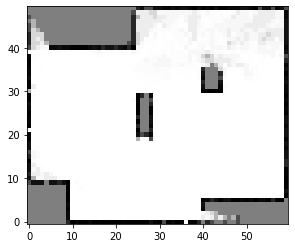

In [11]:
belief_map = ms[-1]
plt.imshow(belief_map, cmap="gray_r", origin='lower')

In [12]:
from ipywidgets import interact, widgets
%matplotlib inline

def plot_OGM(threshold=0.05):
    occupancy_grid = (belief_map > threshold)*255
    plt.imshow(occupancy_grid,cmap="gray_r", origin='lower') # Show binary Occupancy grid
    
interact(plot_OGM, threshold=(0.0 ,1.0, 0.05))

interactive(children=(FloatSlider(value=0.05, description='threshold', max=1.0, step=0.05), Output()), _dom_cl…

<function __main__.plot_OGM(threshold=0.05)>